# Segmentação de Clientes em Marketing

# Libs

In [116]:
import threadpoolctl
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")


In [117]:
np.random.seed(42)

In [118]:
df = pd.read_csv('dataset.csv')
df.head()

,Idade,Gasto_Mensal,Tempo_de_Assinatura,Taxa_de_Uso,Suporte_Tickets,Cancelou
0,48,529.152948,13,0.524262,2,1
1,37,684.502168,13,0.628494,2,0
2,31,797.016155,17,0.706550,1,0
3,30,542.025205,12,0.517458,3,0
4,44,655.498896,15,0.774564,3,0


# Análise Exploratória e Tratamento dos Dados

In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Idade                99 non-null     int64  
 1   Gasto_Mensal         99 non-null     float64
 2   Tempo_de_Assinatura  99 non-null     int64  
 3   Taxa_de_Uso          99 non-null     float64
 4   Suporte_Tickets      99 non-null     int64  
 5   Cancelou             99 non-null     int64  
dtypes: float64(2), int64(4)
memory usage: 4.8 KB


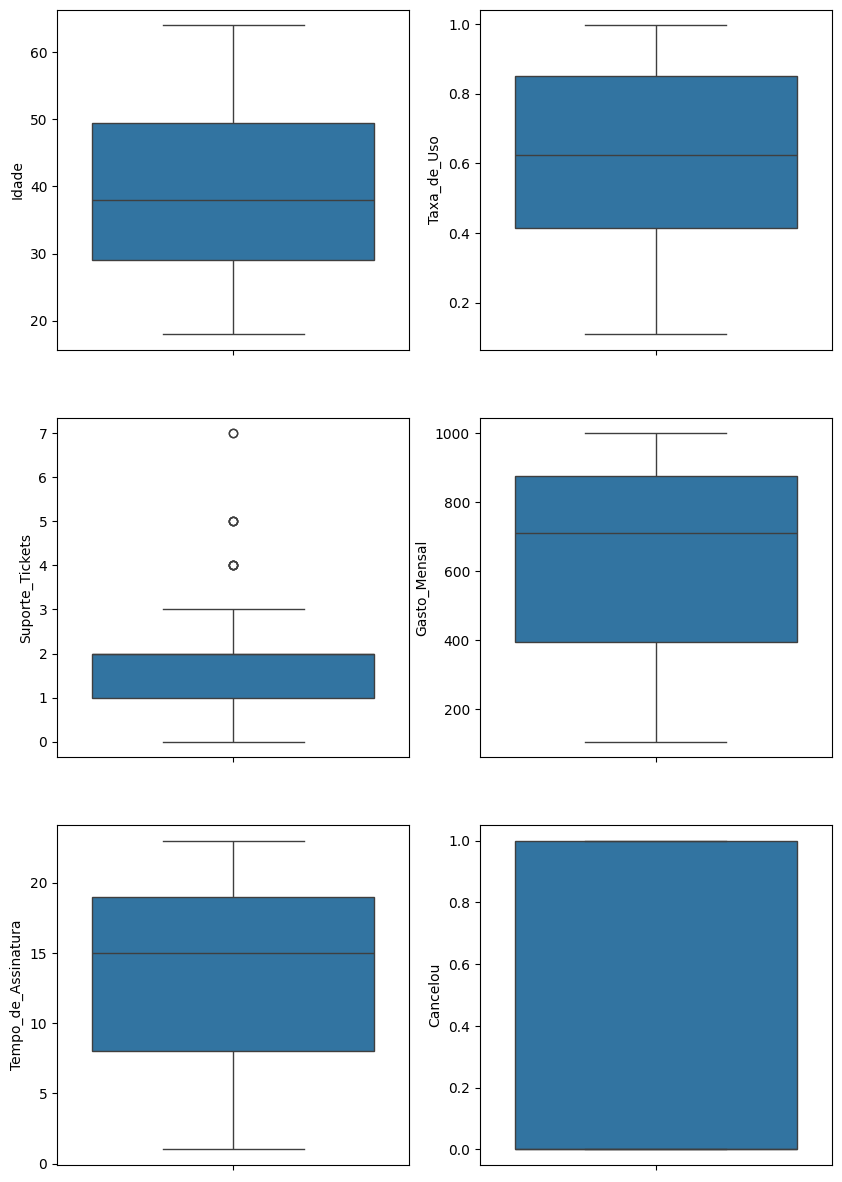

In [120]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize = (10, 15))
for i, col in enumerate(df.columns):
    sns.boxplot(y = df[col], ax = ax[i%3, i%2])

In [121]:
df.describe()

,Idade,Gasto_Mensal,Tempo_de_Assinatura,Taxa_de_Uso,Suporte_Tickets,Cancelou
count,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
mean,39.888889,639.071009,13.646465,0.604374,1.747475,0.494949
std,13.089869,270.618268,6.599804,0.263824,1.486974,0.502519
min,18.000000,106.254563,1.000000,0.110168,0.000000,0.000000
25%,29.000000,394.918421,8.000000,0.414928,1.000000,0.000000
50%,38.000000,709.104722,15.000000,0.623406,2.000000,0.000000
75%,49.500000,875.735422,19.000000,0.849839,2.000000,1.000000
max,64.000000,999.943535,23.000000,0.996007,7.000000,1.000000


In [122]:
# Calculando Intervalo Interquartil
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

In [123]:
# Visualizando os outliers
outliers = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis= 1)
df[outliers]

,Idade,Gasto_Mensal,Tempo_de_Assinatura,Taxa_de_Uso,Suporte_Tickets,Cancelou
12,46,743.034018,16,0.697133,5,0
52,41,595.076602,14,0.512320,4,1
53,48,550.847824,12,0.619646,7,1
54,43,667.040379,13,0.630056,5,0
63,34,694.989179,17,0.536049,7,1
79,59,805.273395,21,0.887495,4,1
80,45,875.292673,23,0.980832,4,1
87,52,968.423785,19,0.989904,4,1
89,56,893.738632,23,0.985318,4,1
95,53,999.943535,23,0.865750,5,1


Text(0.5, 1.0, 'Análise de Multicolinearidade')

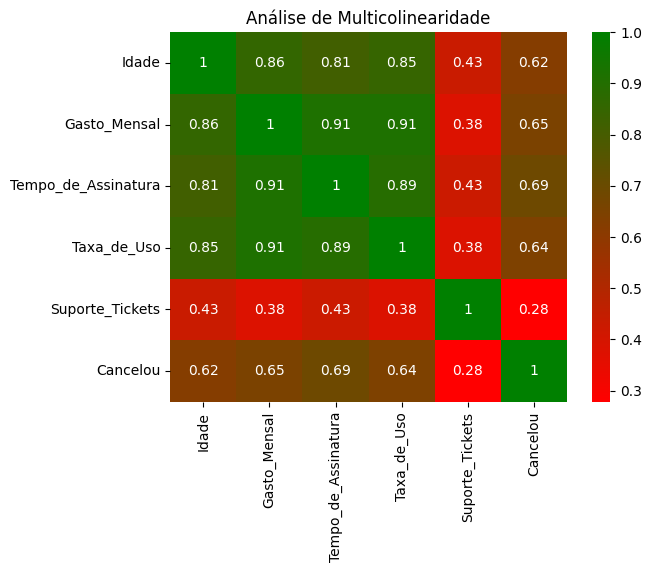

In [124]:
from  matplotlib.colors import LinearSegmentedColormap
cmap=LinearSegmentedColormap.from_list('rg',["r","g"], N=256) 
sns.heatmap(data = df.corr(), annot=True, fmt='.2g', cmap= cmap)
plt.title('Análise de Multicolinearidade')

In [125]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(data = scaler.fit_transform(df), columns= scaler.feature_names_in_)
df_scaled

,Idade,Gasto_Mensal,Tempo_de_Assinatura,Taxa_de_Uso,Suporte_Tickets,Cancelou
0,0.622801,-0.408241,-0.098451,-0.305201,0.170689,1.010153
1,-0.221820,0.168733,-0.098451,0.091893,0.170689,-0.989949
2,-0.682522,0.586616,0.510712,0.389261,-0.505240,-0.989949
3,-0.759306,-0.360433,-0.250741,-0.331122,0.846619,-0.989949
4,0.315666,0.061014,0.206131,0.648375,0.846619,-0.989949
...,...,...,...,...,...,...
94,0.699585,1.201528,0.663003,1.120623,0.170689,1.010153
95,1.006720,1.340298,1.424457,0.995766,2.198477,1.010153
96,0.622801,1.338009,1.119875,1.227891,2.198477,1.010153
97,1.620990,1.010278,1.272166,0.928254,0.170689,1.010153


# Descobrir o Melhor K pelo Método do Cotovelo

Text(0.5, 1.0, 'Método do Cotovelo para K')

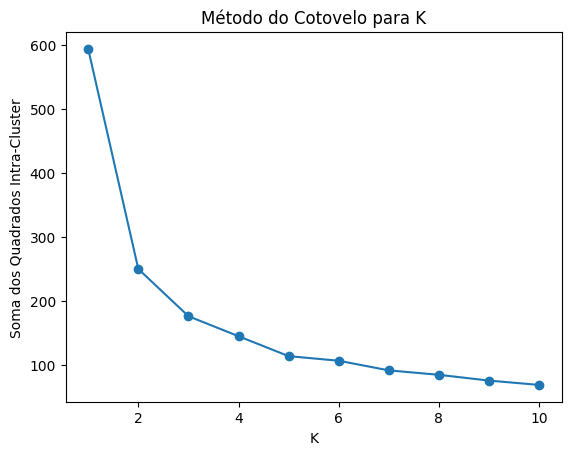

In [126]:
sse = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(df_scaled)
    sse.append(kmeans.inertia_) # Erros intra cluster

# Plot do Cotovelo

plt.plot(k_range, sse, '-o')
plt.xlabel('K')
plt.ylabel('Soma dos Quadrados Intra-Cluster')
plt.title('Método do Cotovelo para K')

In [127]:
sil_score = []
k_range = range(1, 11)
for k in k_range:
    if k != 1:
        kmeans = KMeans(n_clusters = k)
        kmeans.fit(df_scaled)
        labels = kmeans.labels_
        sil_score.append(silhouette_score(df_scaled, labels))

Text(0.5, 1.0, 'Método Silhouette Score para K ótimo')

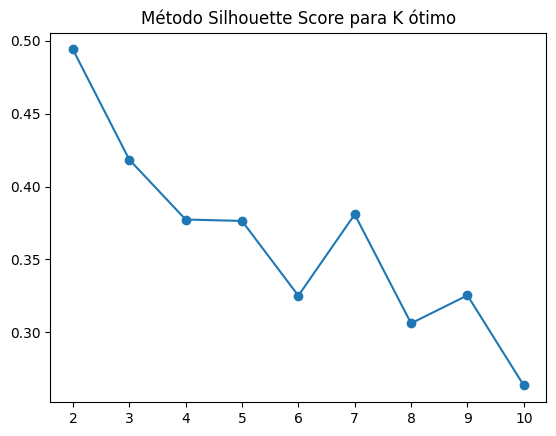

In [128]:
plt.plot(k_range[1:], sil_score, '-o')
plt.title("Método Silhouette Score para K ótimo")

# Modelo V1

In [129]:
kmeans_v1 = KMeans(n_clusters = 4, random_state = 42)
df['cluster'] = kmeans_v1.fit_predict(df_scaled)
df

,Idade,Gasto_Mensal,Tempo_de_Assinatura,Taxa_de_Uso,Suporte_Tickets,Cancelou,cluster
0,48,529.152948,13,0.524262,2,1,2
1,37,684.502168,13,0.628494,2,0,3
2,31,797.016155,17,0.706550,1,0,2
3,30,542.025205,12,0.517458,3,0,3
4,44,655.498896,15,0.774564,3,0,3
...,...,...,...,...,...,...,...
94,49,962.580202,18,0.898524,2,1,1
95,53,999.943535,23,0.865750,5,1,1
96,48,999.327367,21,0.926680,5,1,1
97,61,911.086341,22,0.848029,2,1,1


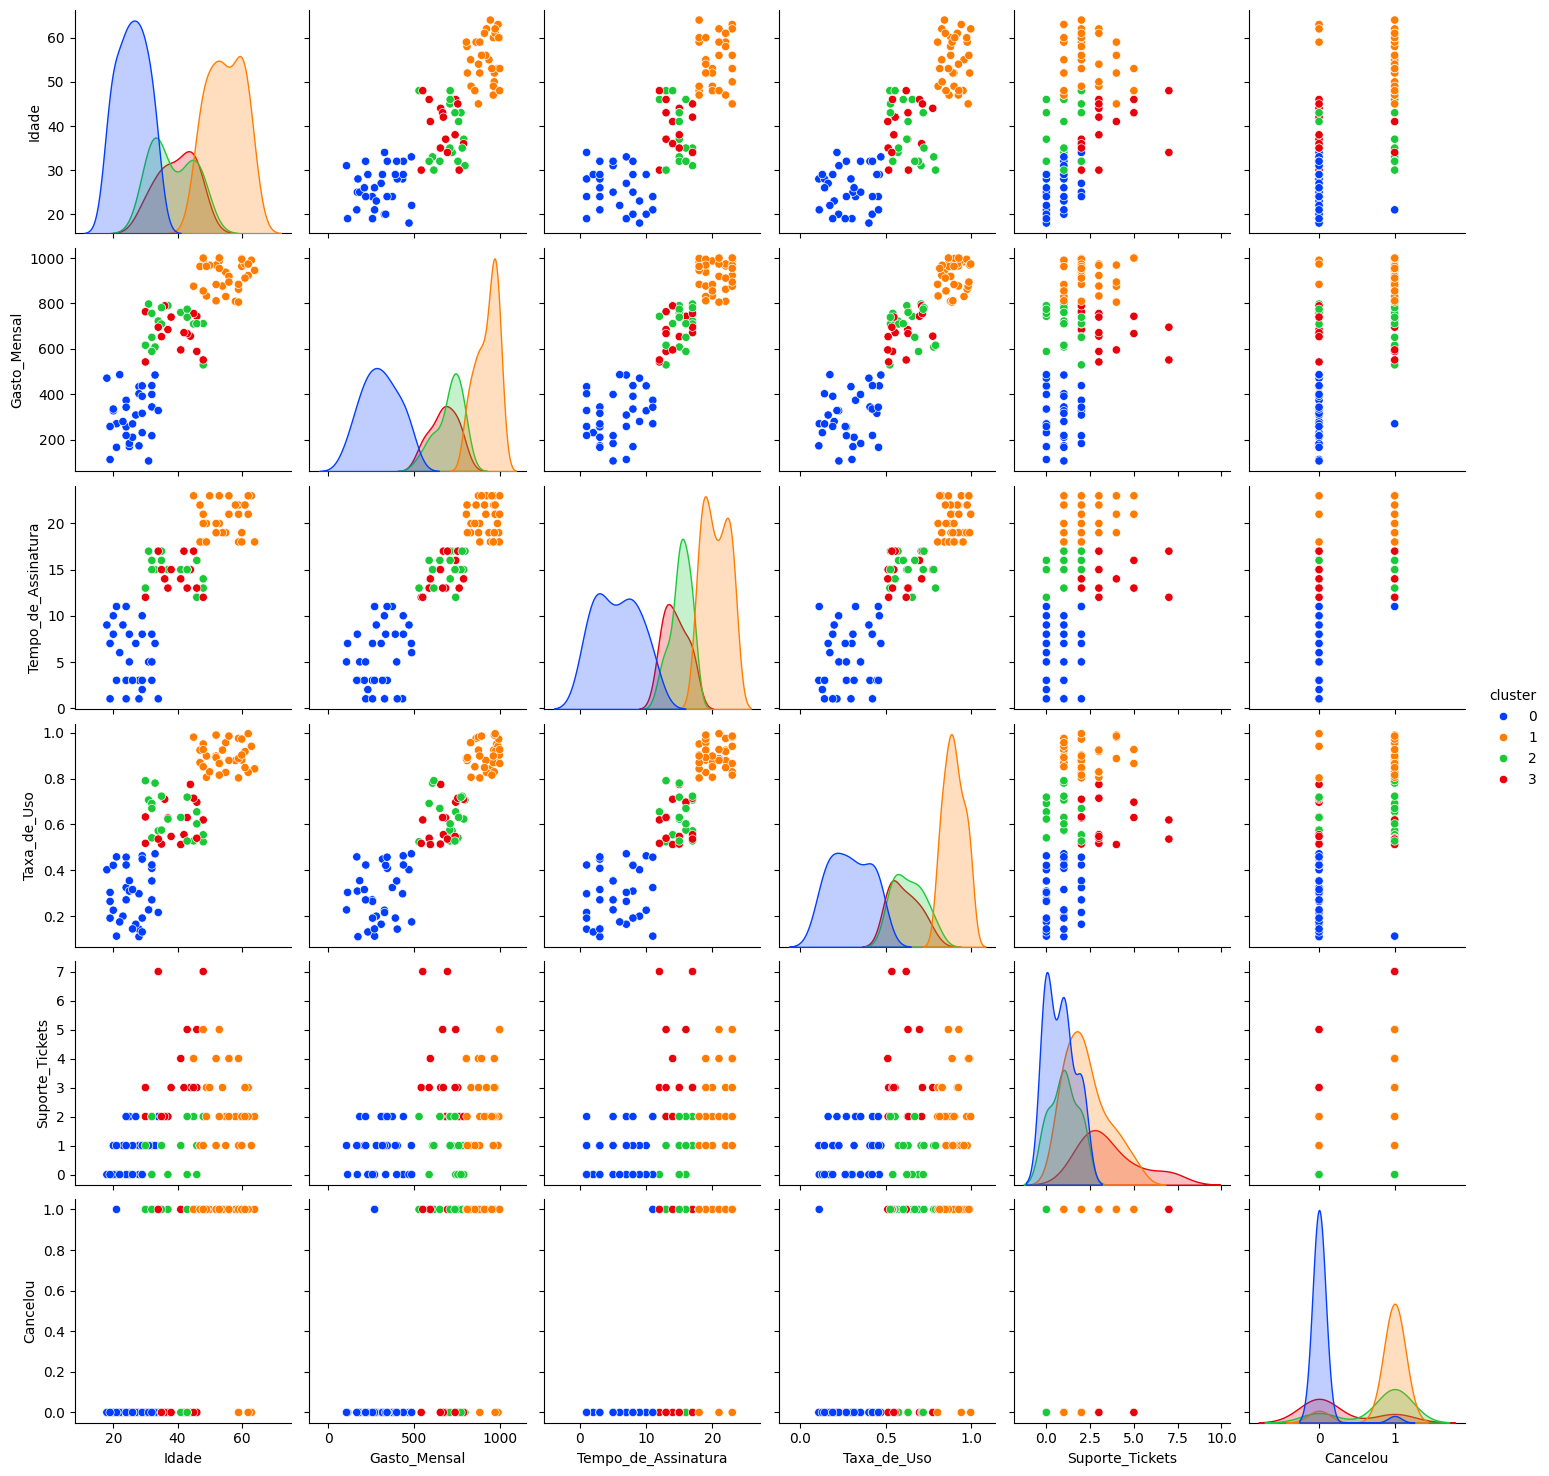

In [134]:
colors = sns.color_palette('bright', n_colors= df['cluster'].unique().size)
sns.pairplot(df, hue='cluster', palette=colors)
plt.show()

Como podemos ver existe uma sobreposição entre dois grupos que poderiam ser um só.    
Logo, para resolvermos esse problema de sobreposição de clusters, utilizaremos apenas 3 grupos, ou seja, K=3. 

# Modelo V2

In [135]:
kmeans_v2 = KMeans(n_clusters = 3, random_state = 42)
df['cluster'] = kmeans_v2.fit_predict(df_scaled)
df

,Idade,Gasto_Mensal,Tempo_de_Assinatura,Taxa_de_Uso,Suporte_Tickets,Cancelou,cluster
0,48,529.152948,13,0.524262,2,1,2
1,37,684.502168,13,0.628494,2,0,2
2,31,797.016155,17,0.706550,1,0,2
3,30,542.025205,12,0.517458,3,0,2
4,44,655.498896,15,0.774564,3,0,2
...,...,...,...,...,...,...,...
94,49,962.580202,18,0.898524,2,1,1
95,53,999.943535,23,0.865750,5,1,1
96,48,999.327367,21,0.926680,5,1,1
97,61,911.086341,22,0.848029,2,1,1


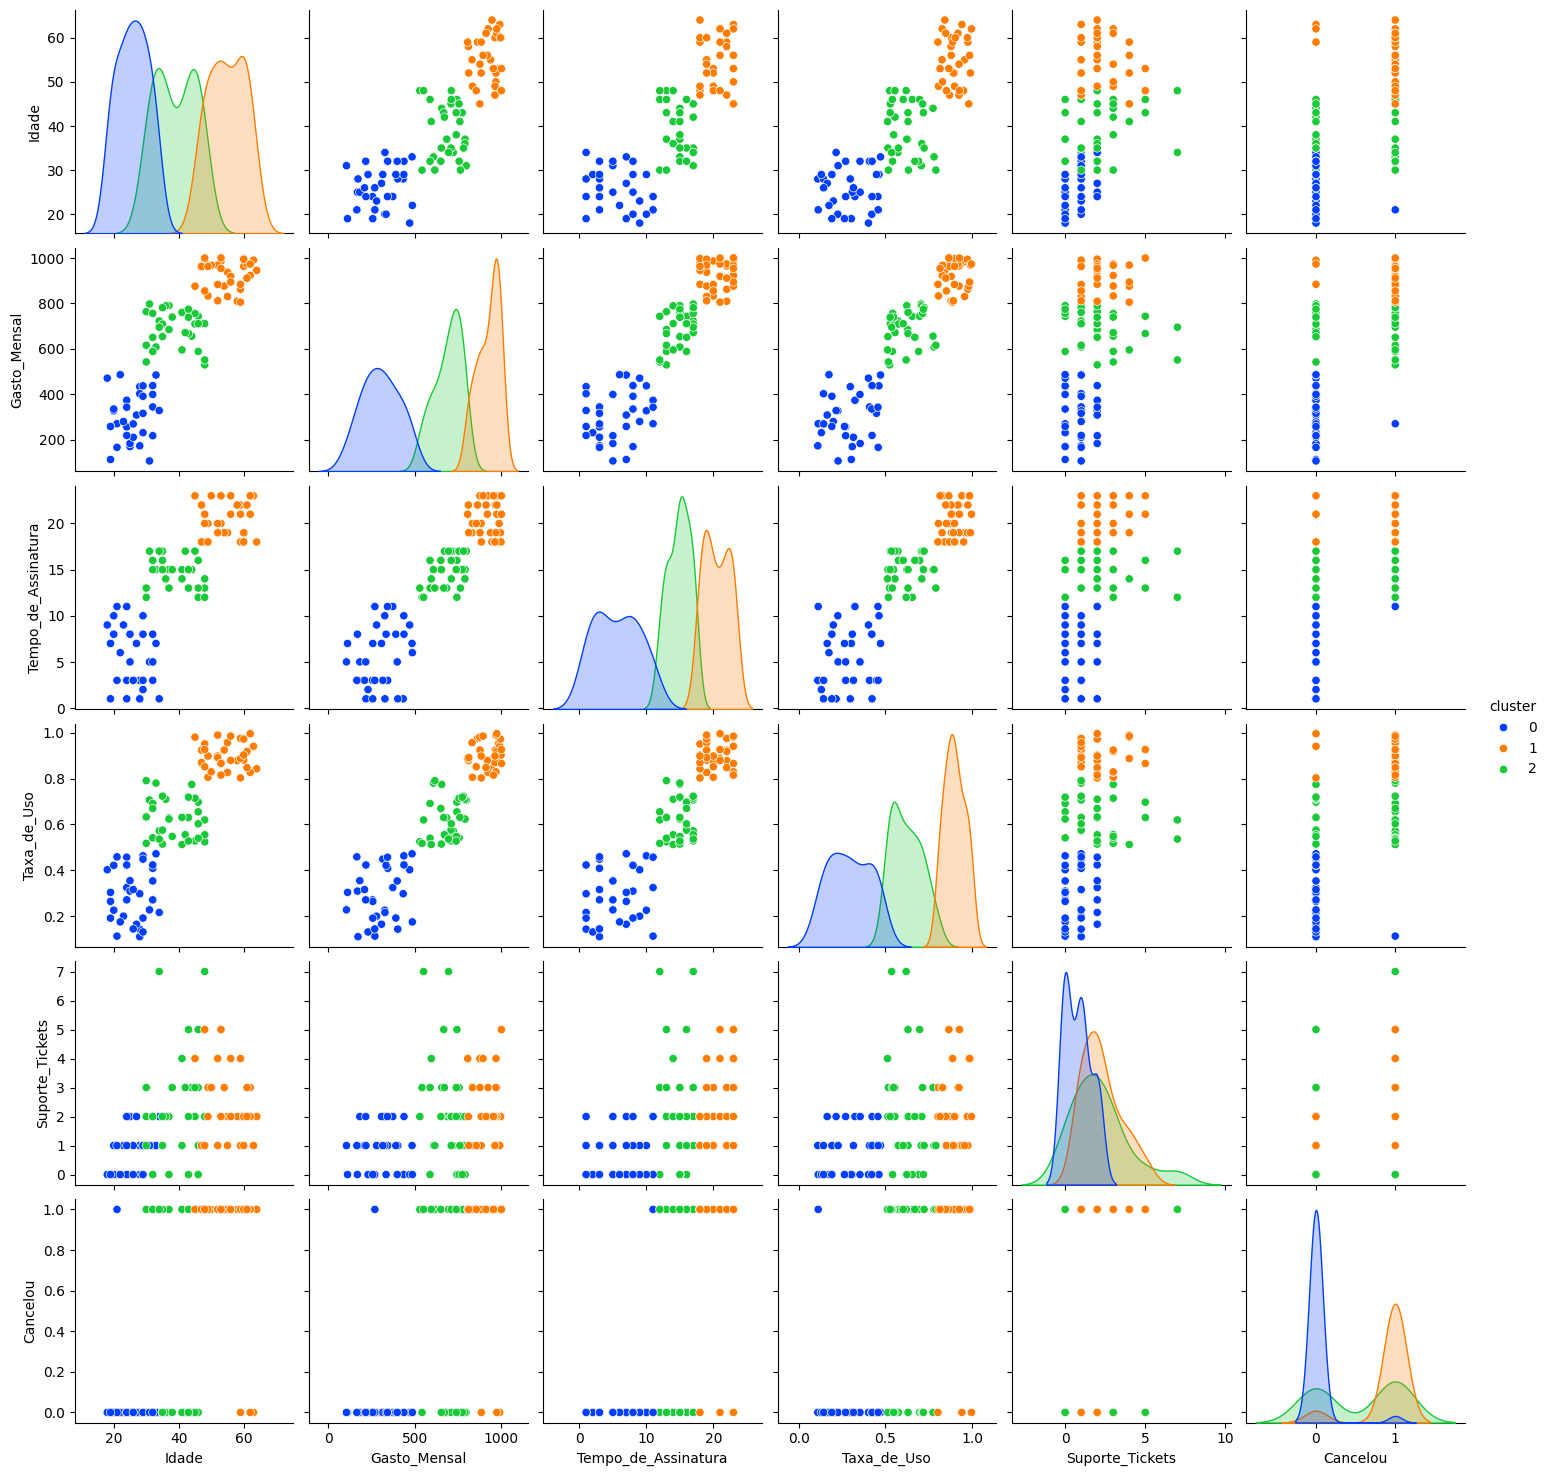

In [136]:
colors = sns.color_palette('bright', n_colors= df['cluster'].unique().size)
sns.pairplot(df, hue='cluster', palette=colors)
plt.show()

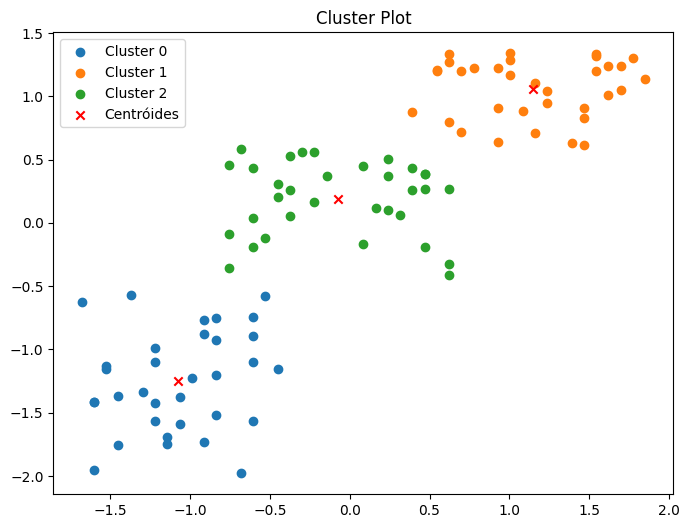

In [228]:
plt.figure(figsize = (8, 6))

for cluster_num in range(3):
    mask = df['cluster'] == cluster_num
    plt.scatter(df_scaled[mask].iloc[:, 0], df_scaled[mask].iloc[:, 1], label = f'Cluster {cluster_num}')

plt.scatter(kmeans_v2.cluster_centers_[:, 0], 
            kmeans_v2.cluster_centers_[:, 1], 
            c = 'red', 
            marker = 'x', 
            label = 'Centróides')
plt.legend()
plt.title("Cluster Plot")
plt.show()

Com 3 clusters o erro intra cluster foi maior. No entanto, os clusters ficaram mais definidos

In [142]:
for grupo in range(0,3):
    print(f'Valores Médios do Grupo {grupo}')
    print(df[df['cluster'] == grupo].mean())
    print('-' * 80)

Valores Médios do Grupo 0
Idade                   25.848485
Gasto_Mensal           302.863443
Tempo_de_Assinatura      5.606061
Taxa_de_Uso              0.293108
Suporte_Tickets          0.787879
Cancelou                 0.030303
cluster                  0.000000
dtype: float64
--------------------------------------------------------------------------------
Valores Médios do Grupo 1
Idade                   54.848485
Gasto_Mensal           923.899857
Tempo_de_Assinatura     20.484848
Taxa_de_Uso              0.897401
Suporte_Tickets          2.272727
Cancelou                 0.909091
cluster                  1.000000
dtype: float64
--------------------------------------------------------------------------------
Valores Médios do Grupo 2
Idade                   38.969697
Gasto_Mensal           690.449726
Tempo_de_Assinatura     14.848485
Taxa_de_Uso              0.622612
Suporte_Tickets          2.181818
Cancelou                 0.545455
cluster                  2.000000
dtype: float64
-

Podemos fazer algumas observações:
- O Grupo 0, possui o dobro da idade do Grupo 1, e o gasto mensal do Grupo 0 é 1/3 do gasto do Grupo 1.
- Apenas 3% dos Clientes cancelaram a assinatura no Grupo 0, contra 90% do Grupo 1 e 55% do Grupo 2.
- Podemos observar que o Grupo 1, possui a maior taxa de uso e o maior índice de cancelamento, o produto está ruim?.
- Muitas observações podem ser feitas mas, uma visão geral é que, clientes mais antigos, que utilizaram mais o produto, tiveram mais problemas com o produto.